In [0]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.regularizers import l1,l2
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, hsv2rgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
import threading
import multiprocessing
import math

def rgb2hsl(rgb):

    def core(_rgb, _hsl):

        irgb = _rgb.astype(np.uint16)
        ir, ig, ib = irgb[:, :, 0], irgb[:, :, 1], irgb[:, :, 2]
        h, s, l = _hsl[:, :, 0], _hsl[:, :, 1], _hsl[:, :, 2]

        imin, imax = irgb.min(2), irgb.max(2)
        iadd, isub = imax + imin, imax - imin

        ltop = (iadd != 510) * (iadd > 255)
        lbot = (iadd != 0) * (ltop == False)

        l[:] = iadd.astype(np.float) / 510

        fsub = isub.astype(np.float)
        s[ltop] = fsub[ltop] / (510 - iadd[ltop])
        s[lbot] = fsub[lbot] / iadd[lbot]

        not_same = imax != imin
        is_b_max = not_same * (imax == ib)
        not_same_not_b_max = not_same * (is_b_max == False)
        is_g_max = not_same_not_b_max * (imax == ig)
        is_r_max = not_same_not_b_max * (is_g_max == False) * (imax == ir)

        h[is_r_max] = ((0. + ig[is_r_max] - ib[is_r_max]) / isub[is_r_max])
        h[is_g_max] = ((0. + ib[is_g_max] - ir[is_g_max]) / isub[is_g_max]) + 2
        h[is_b_max] = ((0. + ir[is_b_max] - ig[is_b_max]) / isub[is_b_max]) + 4
        h[h < 0] += 6
        h[:] /= 6

    hsl = np.zeros(rgb.shape, dtype=np.float)
    cpus = multiprocessing.cpu_count()
    length = int(math.ceil(float(hsl.shape[0]) / cpus))
    line = 0
    threads = []
    while line < hsl.shape[0]:
        line_next = line + length
        thread = threading.Thread(target=core, args=(rgb[line:line_next], hsl[line:line_next]))
        thread.start()
        threads.append(thread)
        line = line_next

    for thread in threads:
        thread.join()

    return hsl

def hsl2rgb(hsl):

    def core(_hsl, _frgb):

        h, s, l = _hsl[:, :, 0], _hsl[:, :, 1], _hsl[:, :, 2]
        fr, fg, fb = _frgb[:, :, 0], _frgb[:, :, 1], _frgb[:, :, 2]

        q = np.zeros(l.shape, dtype=np.float)

        lbot = l < 0.5
        q[lbot] = l[lbot] * (1 + s[lbot])

        ltop = lbot == False
        l_ltop, s_ltop = l[ltop], s[ltop]
        q[ltop] = (l_ltop + s_ltop) - (l_ltop * s_ltop)

        p = 2 * l - q
        q_sub_p = q - p

        is_s_zero = s == 0
        l_is_s_zero = l[is_s_zero]
        per_3 = 1./3
        per_6 = 1./6
        two_per_3 = 2./3

        def calc_channel(channel, t):

            t[t < 0] += 1
            t[t > 1] -= 1
            t_lt_per_6 = t < per_6
            t_lt_half = (t_lt_per_6 == False) * (t < 0.5)
            t_lt_two_per_3 = (t_lt_half == False) * (t < two_per_3)
            t_mul_6 = t * 6

            channel[:] = p.copy()
            channel[t_lt_two_per_3] = p[t_lt_two_per_3] + q_sub_p[t_lt_two_per_3] * (4 - t_mul_6[t_lt_two_per_3])
            channel[t_lt_half] = q[t_lt_half].copy()
            channel[t_lt_per_6] = p[t_lt_per_6] + q_sub_p[t_lt_per_6] * t_mul_6[t_lt_per_6]
            channel[is_s_zero] = l_is_s_zero.copy()

        calc_channel(fr, h + per_3)
        calc_channel(fg, h.copy())
        calc_channel(fb, h - per_3)

    frgb = np.zeros(hsl.shape, dtype=np.float)
    cpus = multiprocessing.cpu_count()
    length = int(math.ceil(float(hsl.shape[0]) / cpus))
    line = 0
    threads = []
    while line < hsl.shape[0]:
        line_next = line + length
        thread = threading.Thread(target=core, args=(hsl[line:line_next], frgb[line:line_next]))
        thread.start()
        threads.append(thread)
        line = line_next

    for thread in threads:
        thread.join()

    return (frgb*255).round().astype(np.uint8)

In [0]:
# load the dataset
(x_train, _), (x_test, _) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
xtrain_temp=[]
for i in range(x_train.shape[0]):
  xtrain_temp.append(rgb2hsl(x_train[i]))

xtest_temp=[]
for i in range(x_test.shape[0]):
  xtest_temp.append(rgb2hsl(x_test[i]))

  
xtrain = np.asarray(xtrain_temp)
xtest = np.asarray(xtest_temp)
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')


xtrain_red = xtrain[:,:,:,0]
xtrain_green = xtrain[:,:,:,1] 
xtrain_blue = xtrain[:,:,:,2]

xtest_red = xtest[:,:,:,0]
xtest_green = xtest[:,:,:,1] 
xtest_blue = xtest[:,:,:,2]

xtrain_red = xtrain_red.reshape(len(xtrain_red), np.prod(xtrain_red.shape[1:]))
xtrain_green = xtrain_green.reshape(len(xtrain_green), np.prod(xtrain_green.shape[1:]))
xtrain_blue = xtrain_blue.reshape(len(xtrain_blue), np.prod(xtrain_blue.shape[1:]))

xtest_red = xtest_red.reshape(len(xtest_red), np.prod(xtest_red.shape[1:]))
xtest_green = xtest_green.reshape(len(xtest_green), np.prod(xtest_green.shape[1:]))
xtest_blue = xtest_blue.reshape(len(xtest_blue), np.prod(xtest_blue.shape[1:]))


train_dset = []
train_dset.extend(xtrain_red)
train_dset.extend(xtrain_green)
train_dset.extend(xtrain_blue)
dset_train = np.asarray(train_dset)

test_dset = []
test_dset.extend(xtest_red)
test_dset.extend(xtest_green)
test_dset.extend(xtest_blue)
dset_test = np.asarray(test_dset)

In [0]:
input_layer = xtrain_red.shape[1]
hid_layer1 = 576
hid_layer2 = 256
hid_layer3 = 64
hid_layer4 = 10
hid_layer5 = hid_layer3
hid_layer6 = hid_layer2
hid_layer7 = hid_layer1
output_layer = input_layer
print(dset_train.shape)
print(dset_test.shape)

(150000, 1024)
(30000, 1024)


In [0]:
input_img = Input(shape=(input_layer,))

W0817 12:28:02.753323 140065295914880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 12:28:02.801090 140065295914880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
# network architecture
# vanilla autoencoder with fully-connected layer
# ENCODER
x = Dense(units = hid_layer1, activation='relu')(input_img)
x = Dense(units = hid_layer2, activation='relu')(x)
x = Dense(units = hid_layer3, activation='relu')(x)

encoded = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(x)

# DECODER
x = Dense(units = hid_layer5, activation = 'relu')(encoded)
x = Dense(units = hid_layer6, activation='relu')(x)
x = Dense(units = hid_layer7, activation='relu')(x)

decoded = Dense(units = output_layer, activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer= Adam(lr=1e-5), loss='mean_absolute_error')

W0817 12:28:02.826890 140065295914880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 12:28:02.996552 140065295914880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 576)               590400    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               147712    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
__________

In [0]:
# train the model
history = autoencoder.fit(dset_train, dset_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(dset_test, dset_test))

W0817 12:28:03.266426 140065295914880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0817 12:28:03.515225 140065295914880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 150000 samples, validate on 30000 samples
Epoch 1/100
150000/150000 [==============================] - 18s 121us/step - loss: 0.2149 - val_loss: 0.1690
Epoch 2/100
150000/150000 [==============================] - 14s 94us/step - loss: 0.1530 - val_loss: 0.1410
Epoch 3/100
150000/150000 [==============================] - 14s 94us/step - loss: 0.1344 - val_loss: 0.1289
Epoch 4/100
150000/150000 [==============================] - 14s 93us/step - loss: 0.1258 - val_loss: 0.1219
Epoch 5/100
150000/150000 [==============================] - 14s 94us/step - loss: 0.1188 - val_loss: 0.1172
Epoch 6/100
150000/150000 [==============================] - 14s 93us/step - loss: 0.1165 - val_loss: 0.1158
Epoch 7/100
150000/150000 [==============================] - 14s 91us/step - loss: 0.1156 - val_loss: 0.1149
Epoch 8/100
150000/150000 [==============================] - 14s 93us/step - loss: 0.1151 - val_loss: 0.1147
Epoch 9/100
150000/150000 [==============================] - 14s 93us/step -

dict_keys(['val_loss', 'loss'])


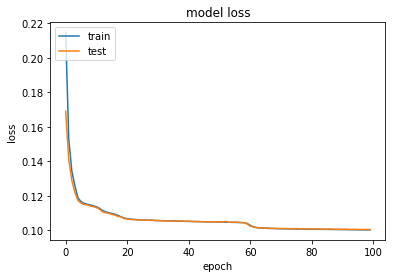

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

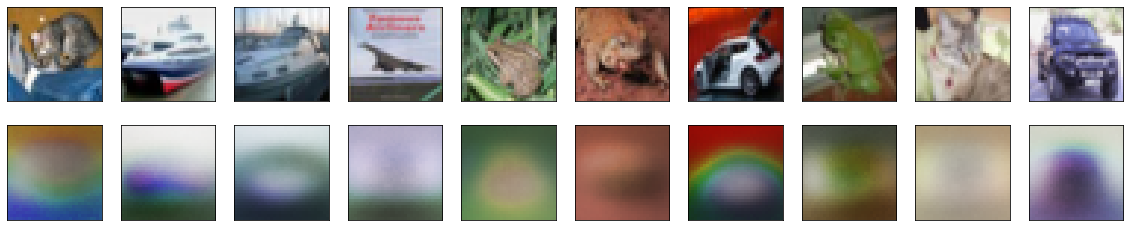

In [0]:
# show the result at the decoder output
decoded_imgs_red = autoencoder.predict(xtest_red)
decoded_imgs_green = autoencoder.predict(xtest_green)
decoded_imgs_blue = autoencoder.predict(xtest_blue)

counter = 0
n = 10
test_imgs = np.zeros((32,32,3))
dec_imgs = np.zeros((32,32,3))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    test_imgs[:,:,0] = xtest_red[counter + i].reshape(32, 32)
    test_imgs[:,:,1] = xtest_green[counter + i].reshape(32, 32)
    test_imgs[:,:,2] = xtest_blue[counter + i].reshape(32, 32)

    plt.imshow(hsl2rgb(test_imgs))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    dec_imgs[:,:,0] = decoded_imgs_red[counter + i].reshape(32, 32)
    dec_imgs[:,:,1] = decoded_imgs_green[counter + i].reshape(32, 32)
    dec_imgs[:,:,2] = decoded_imgs_blue[counter + i].reshape(32, 32)

    plt.imshow(hsl2rgb(dec_imgs))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

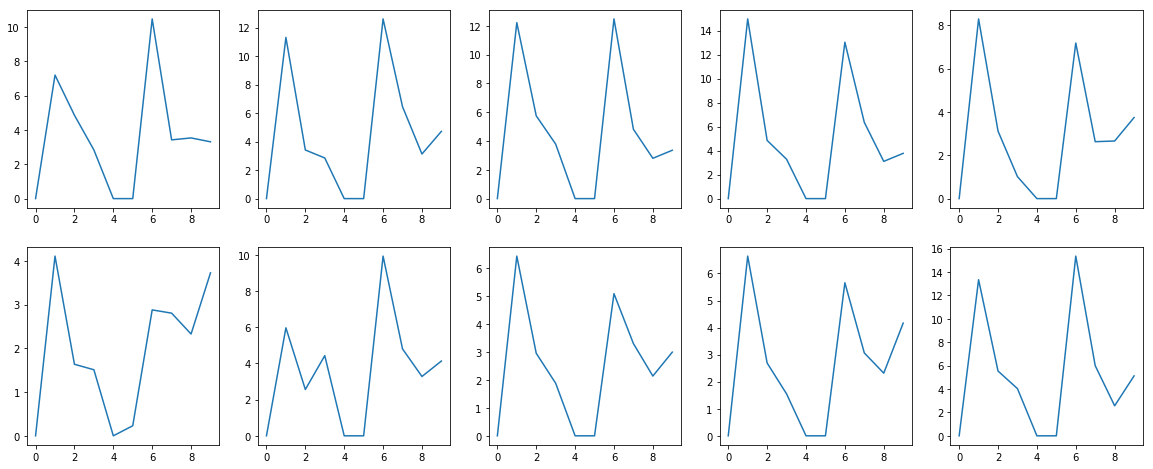

In [0]:
# show the representation at the bottleneck
encoded_imgs_red = encoder.predict(xtest_red)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_red[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

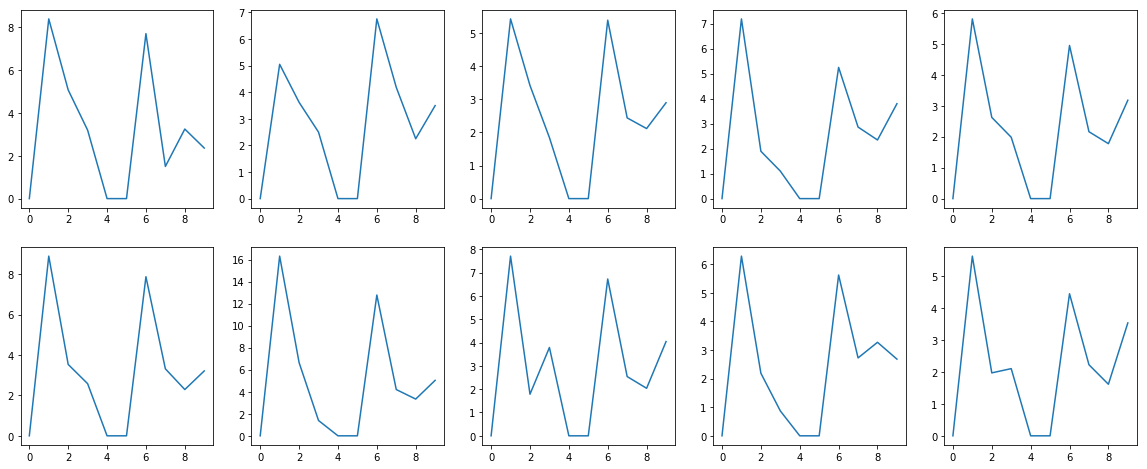

In [0]:
# show the representation at the bottleneck
encoded_imgs_green = encoder.predict(xtest_green)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_green[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

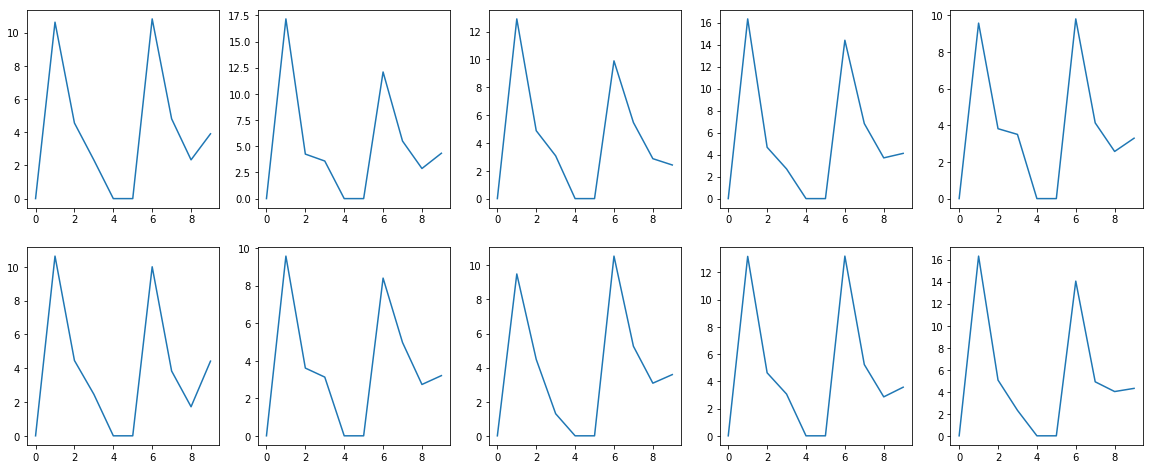

In [0]:
# show the representation at the bottleneck
encoded_imgs_blue = encoder.predict(xtest_blue)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_blue[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

In [0]:
autoencoder.save('autoencoder_baseline_hsl.h5')

In [0]:
from keras.models import load_model
test_model = load_model('autoencoder_baseline_hsl.h5')

encoding = Input(shape = (hid_layer4,))
# DECODER
y = Dense(units = hid_layer5, activation = 'relu')(encoding)
y = Dense(units = hid_layer6, activation='relu')(y)
y = Dense(units = hid_layer7, activation='relu')(y)

decode_avg = Dense(units = output_layer, activation='sigmoid')(y)

newModel = Model(encoding, decode_avg)
newModel.summary()
newModel.layers[1].set_weights(test_model.layers[5].get_weights())
newModel.layers[2].set_weights(test_model.layers[6].get_weights())
newModel.layers[3].set_weights(test_model.layers[7].get_weights())
newModel.layers[4].set_weights(test_model.layers[8].get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 576)               148032    
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              590848    
Total params: 756,224
Trainable params: 756,224
Non-trainable params: 0
_________________________________________________________________


In [0]:
avg_bottleneck = (encoded_imgs_red + encoded_imgs_green + encoded_imgs_blue)/3.

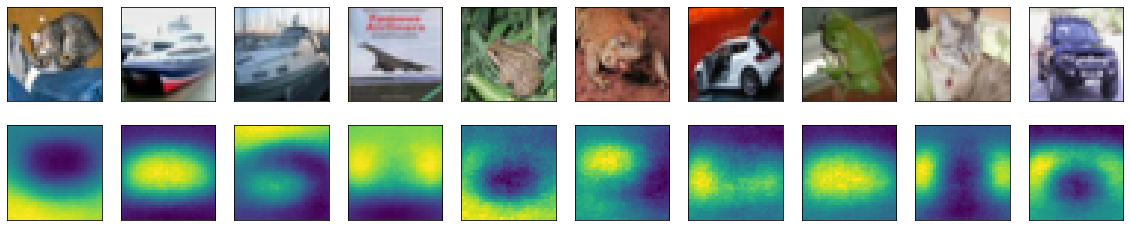

In [0]:
# show the result at the decoder output
decoded_imgs = newModel.predict(avg_bottleneck)

n = 10
test_imgs = np.zeros((32,32,3))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    test_imgs[:,:,0] = xtest_red[counter + i].reshape(32, 32)
    test_imgs[:,:,1] = xtest_green[counter + i].reshape(32, 32)
    test_imgs[:,:,2] = xtest_blue[counter + i].reshape(32, 32)

    plt.imshow(hsl2rgb(test_imgs))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[counter + i].reshape(32,32))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(array([316., 383., 109.,  44.,  47.,  43.,  36.,  19.,  16.,  11.]),
 array([2.4886429e-04, 7.5699933e-02, 1.5115100e-01, 2.2660208e-01,
        3.0205315e-01, 3.7750420e-01, 4.5295528e-01, 5.2840632e-01,
        6.0385740e-01, 6.7930847e-01, 7.5475955e-01], dtype=float32),
 <a list of 10 Patch objects>)

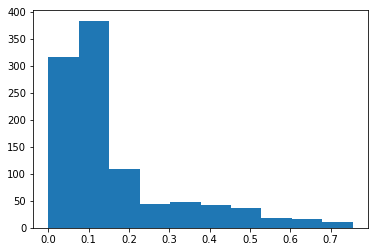

In [0]:
err_red = np.sqrt(np.square(xtest_red[1] - decoded_imgs_red[1]))
plt.hist(err_red)

(array([520., 274.,  89.,  58.,  25.,  16.,  14.,   7.,   5.,  16.]),
 array([5.4390356e-04, 7.6101542e-02, 1.5165918e-01, 2.2721681e-01,
        3.0277446e-01, 3.7833208e-01, 4.5388973e-01, 5.2944738e-01,
        6.0500497e-01, 6.8056262e-01, 7.5612026e-01], dtype=float32),
 <a list of 10 Patch objects>)

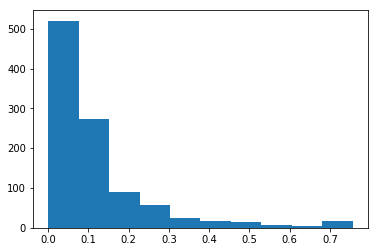

In [0]:
err_green = np.sqrt(np.square(xtest_green[1] - decoded_imgs_green[1]))
plt.hist(err_green)

(array([350., 163., 132., 127., 102.,  57.,  43.,  26.,  10.,  14.]),
 array([2.8073788e-05, 4.9051892e-02, 9.8075710e-02, 1.4709952e-01,
        1.9612335e-01, 2.4514717e-01, 2.9417098e-01, 3.4319481e-01,
        3.9221862e-01, 4.4124246e-01, 4.9026626e-01], dtype=float32),
 <a list of 10 Patch objects>)

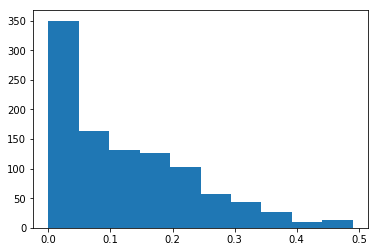

In [0]:
err_blue = np.sqrt(np.square(xtest_blue[1] - decoded_imgs_blue[1]))
plt.hist(err_blue)